## Scatter plots and associated analysis

In [ ]:
import xarray as xr
import os
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy import stats 
from scipy.interpolate import griddata, RectBivariateSpline
import matplotlib.pyplot as plt 
import statistics 
#import seaborn as sns
from tqdm.auto import tqdm 
import operator as op
import cartopy as cart
import matplotlib.ticker as mticker
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
#from mpl_toolkits.basemap import Basemap, interp
import matplotlib.colors as colors
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import kstest, mannwhitneyu, ks_2samp
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.dates as mdates
import cartopy
import cartopy.feature as cfeature

In [2]:
from datetime import timedelta
import datetime

In [3]:
%cd ERA5/precip_dailytotal
#first re-grid on 360x180 grid with 1x1 gridcells
yearly_precip_regridded = xr.open_dataset('precip_daily_total_1979-2019_regrid.nc', engine='netcdf4')
#yearly_precip_regridded

D:\RainHeatData\ERA5\precip_dailytotal


In [4]:
#convert ERA5 precipitation to mm
yearly_precip_regridded = yearly_precip_regridded.tp*1000

In [5]:
%cd ..
%cd humid_heat\regridded_daymeans
all_tw_regridded = xr.open_dataset('TW_daily_max_1979-2020_daymean_regridded.nc', engine='netcdf4')
#all_tw_regridded
%cd ..
%cd ..
%cd ..
daily_precip_regrid = xr.open_dataset('NOAA_CPC/precip_daily_total_1979-2022_regrid.nc', engine='netcdf4')
daily_precip_regrid
#%cd RainHeatData
%cd ERA5/2mtemp_dailymean/processed
#2mtemp_dailymax from ERA5
temp_dailymean = xr.open_dataset('2mtemp_dailymean_1979-2019_regridded.nc', engine='netcdf4')
#temp_dailymean

D:\RainHeatData\ERA5
D:\RainHeatData\ERA5\humid_heat\regridded_daymeans
D:\RainHeatData\ERA5\humid_heat
D:\RainHeatData\ERA5
D:\RainHeatData
D:\RainHeatData\ERA5\2mtemp_dailymean\processed


In [6]:
%cd ..
%cd ..
%cd specific_humidity_dailymean
spechum_dailymean = xr.open_dataset('spechum_dailymean_1979-2019_regrid.nc', engine='netcdf4')
spechum_dailymean

D:\RainHeatData\ERA5\2mtemp_dailymean
D:\RainHeatData\ERA5
D:\RainHeatData\ERA5\specific_humidity_dailymean


<xarray.Dataset>
Dimensions:  (time: 14975, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    q        (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Sat May 07 09:01:58 2022: cdo remapbil,grid_info.txt spechu...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

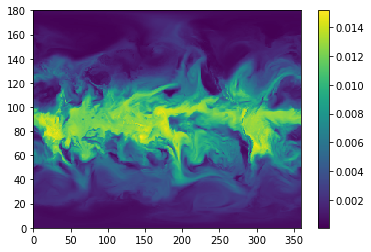

In [32]:
plt.pcolormesh(spechum_dailymean.q.isel(time=0))
plt.colorbar()

### select lat/lon

In [7]:
#ERA5 Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data_N = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data_N = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
temp_data_N = temp_dailymean.sel(lon = slice(0,360), lat=slice(0,90))
spechum_data_N = spechum_dailymean.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data_S = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data_S = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))
#temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(-90,0))

In [8]:
june_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 6)
july_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 7)
august_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 8)
JJA_idx = np.concatenate([june_months, july_months, august_months])
#JJA_idx

#december_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 12)
#january_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 1)
#february_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 2)
#DJF_idx = np.concatenate([december_months, january_months, february_months])

In [9]:
#spechum_data_N

In [9]:
#select summer months
precip_data_JJA = precip_data_N.where(precip_data_N.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data_N.where(TW_data_N.time.dt.month.isin([6,7,8]),drop=True).TW
temp_data_JJA = temp_data_N.where(temp_data_N.time.dt.month.isin([6,7,8]),drop=True).t2m
spechum_data_JJA = spechum_data_N.where(spechum_data_N.time.dt.month.isin([6,7,8]),drop=True).q

In [12]:
#spechum_data_JJA


## Select Location

In [10]:
#regional breakdown - NYC
lon_1=285.5 #282.5
lon_2=286.5 #289.5
lat_1=40.5 #49.5
lat_2=41.5 #55.5

#precip_data = precip_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
precip_data = yearly_precip_regridded.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))

#TW_data = TW_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
TW_data = all_tw_regridded.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))

#spechum_data = spechum_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
spechum_data = spechum_dailymean.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))

In [64]:
#OR
#Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
spechum_data = spechum_dailymean.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))

In [11]:
#cut TW time so data are the same
TW_data = TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
precip_data = precip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
spechum_data = spechum_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

#select JJA months - summer for North Hem
precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([6,7,8]),drop=True).TW
spechum_data_JJA = spechum_data.where(spechum_data.time.dt.month.isin([6,7,8]),drop=True)
#.TW

#select DJF months - summer for Southern Hem
#precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([12,1,2]),drop=True) #tp for ERA5
#TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([12,1,2]),drop=True).TW

In [12]:
precip_data_JJA.shape[1]

2

In [10]:
spechum_mean = spechum_data_JJA.mean(dim='time')

In [13]:
### Daily Precip Anomalies ###
#daily average
precip_mean = precip_data_JJA.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = precip_data_JJA.rolling(time = 30, center = True).mean('time')
#anomaly
precip_data = precip_data_JJA.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time')

### Daily Max TW Anomalies ###
#daily average
TW_mean = TW_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = TW_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data = TW_data_JJA.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')

### Daily mean specific humidity anomalies ###
#daily average
#spechum_mean = spechum_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
#spechum_rolling = spechum_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
#spechum_data = spechum_data_JJA.groupby('time.dayofyear') - spechum_rolling.groupby('time.dayofyear').mean(dim='time')

(array([2.9000e+01, 4.7800e+02, 3.0260e+03, 1.7931e+04, 5.0601e+04,
        6.8151e+04, 5.1347e+04, 1.7174e+04, 2.3780e+03, 1.1700e+02]),
 array([-16.485804 , -13.475869 , -10.465935 ,  -7.456001 ,  -4.446067 ,
         -1.4361324,   1.5738018,   4.583736 ,   7.5936704,  10.603604 ,
         13.613539 ], dtype=float32),
 <BarContainer object of 10 artists>)

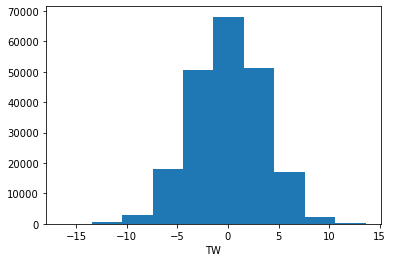

In [77]:
### Section off Land coordinates only before running loop ###
#spechum_data_JJA

TW_data.plot()

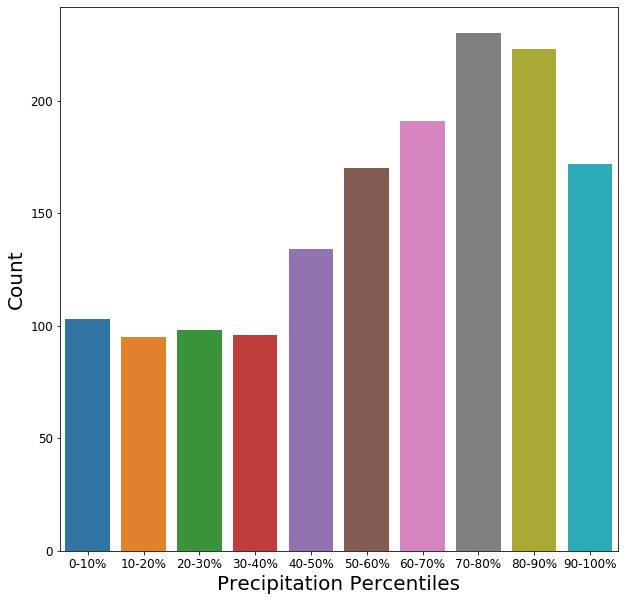

In [16]:
## bar plot ##
import seaborn as sns
raw_percentile_cutoff_JJA = np.zeros((precip_data.shape[1], precip_data.shape[2]))
precip_days=[]
raw_TW_percentile_cutoff_JJA = np.zeros((precip_data.shape[1], precip_data.shape[2]))
TW_days=[]
combo_days_ts = np.zeros((precip_data.shape[1], precip_data.shape[2],699))
rain_threshold = 1
pc = 90
fig,ax = plt.subplots()
ax.figure.set_size_inches(10,10)
counts_TW = [0,0,0,0,0,0,0,0,0,0]
counts_precip= [0,0,0,0,0,0,0,0,0,0]
counts_TW = np.zeros((precip_data.shape[1], precip_data.shape[2],10))
counts_precip =np.zeros((precip_data.shape[1], precip_data.shape[2],10))
x = ['0-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%']
bins = [0,10,20,30,40,50,60,70,80,90,100]

plt.rcParams.update({'font.size': 12})

for i in range(precip_data.shape[1]):
    
    for j in range(precip_data.shape[2]):
        
        precip_data_for_coordinate = precip_data[:,i,j]
        #precip_pcs = [stats.percentileofscore(precip_data_for_coordinate, a, 'rank') for a in precip_data_for_coordinate]
        precip_pcs = (stats.rankdata(precip_data_for_coordinate, "average")/len(precip_data_for_coordinate))*100
        #idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        #precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        #for >1mm rain days - raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=pc)
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_for_coordinate, q=pc)
        idx_90 = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) > raw_percentile_cutoff_JJA[i][j])) # put into index array
        precip_90_pc = precip_data_for_coordinate[idx_90] # select precip anomalies for this index
        precip_90_pc_days = list(precip_90_pc.time.values)
        #precip_90_idx = precip_90_pc.time.to_dataframe() # put into dataframe, list of dates
        idx_pcs = stats.rankdata(precip_90_pc, "average")/len(precip_90_pc)
        
        TW_data_for_coordinate = TW_data[:,j,i]
        #TW_pcs = [stats.percentileofscore(TW_data_for_coordinate, a, 'rank') for a in TW_data_for_coordinate]
        TW_pcs = (stats.rankdata(TW_data_for_coordinate, "average")/len(TW_data_for_coordinate))*100
        raw_TW_percentile_cutoff_JJA[i][j] = np.nanpercentile(TW_data_for_coordinate, q=pc)
        idx_TW_90 = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) > raw_TW_percentile_cutoff_JJA[i][j])) # put into index array
        TW_90_pc = TW_data_for_coordinate[idx_TW_90] # select precip anomalies for this index
        #TW_90_pc_days = TW_90_pc.time.to_dataframe() # put into dataframe, list of dates
        TW_90_pc_days = list(TW_90_pc.time.values)
        #TW_days.append(TW_90_pc_days)
        idx_TW_pcs = stats.rankdata(TW_90_pc, "average")/len(TW_90_pc)
        
        #combo_days_unique = list(set(precip_90_pc_days+TW_90_pc_days))
        #combo_idx_90 = list(set(idx_90) & set(idx_TW_90))
        #combo_idx_90 = list(set(idx_90)|set(idx_TW_90))  
        
        #combo_days_coord = combo_days_unique[i][j][:]
        #preciptoplot = precip_data_for_coordinate.sel(time=combo_days_unique) 
        #TWtoplot = TW_data_for_coordinate.sel(time=combo_days_unique)
        #precip_percentile_toplot = precip_pcs[combo_idx_90]
            #precip_data_for_coordinate.sel(time=combo_idx_90) #precip_pcs[combo_idx_90]
        #TW_percentile_toplot = TW_pcs[combo_idx_90]
        
        #just precip values
        precip_TW_values = TW_pcs[list(set(idx_90))] # plot these counts
        precip_values = precip_pcs[list(set(idx_90))]
        
        #just TW values
        precip_TW_values_2 = TW_pcs[list(set(idx_TW_90))]
        precip_values_2 = precip_pcs[list(set(idx_TW_90))] #plot these counts
        
        #counts - TW values - make 3D
        counts_TW[i,j,0] = len(precip_TW_values[(precip_TW_values > 0) & (precip_TW_values <= 10)])
        counts_TW[i,j,1] = len(precip_TW_values[(precip_TW_values > 10) & (precip_TW_values <= 20)])
        counts_TW[i,j,2] = len(precip_TW_values[(precip_TW_values > 20) & (precip_TW_values <= 30)])
        counts_TW[i,j,3] = len(precip_TW_values[(precip_TW_values > 30) & (precip_TW_values <= 40)])
        counts_TW[i,j,4] = len(precip_TW_values[(precip_TW_values > 40) & (precip_TW_values <= 50)])
        counts_TW[i,j,5] = len(precip_TW_values[(precip_TW_values > 50) & (precip_TW_values <= 60)])
        counts_TW[i,j,6] = len(precip_TW_values[(precip_TW_values > 60) & (precip_TW_values <= 70)])
        counts_TW[i,j,7] = len(precip_TW_values[(precip_TW_values > 70) & (precip_TW_values <= 80)])
        counts_TW[i,j,8] = len(precip_TW_values[(precip_TW_values > 80) & (precip_TW_values <= 90)])
        counts_TW[i,j,9] = len(precip_TW_values[(precip_TW_values > 90) & (precip_TW_values <= 100)])
        
        #counts - precip values
        counts_precip[i,j,0] = len(precip_values_2[(precip_values_2 > 0) & (precip_values_2 <= 10)])
        counts_precip[i,j,1] = len(precip_values_2[(precip_values_2 > 10) & (precip_values_2 <= 20)])
        counts_precip[i,j,2] = len(precip_values_2[(precip_values_2 > 20) & (precip_values_2 <= 30)])
        counts_precip[i,j,3] = len(precip_values_2[(precip_values_2 > 30) & (precip_values_2 <= 40)])
        counts_precip[i,j,4] = len(precip_values_2[(precip_values_2 > 40) & (precip_values_2 <= 50)])
        counts_precip[i,j,5] = len(precip_values_2[(precip_values_2 > 50) & (precip_values_2 <= 60)])
        counts_precip[i,j,6] = len(precip_values_2[(precip_values_2 > 60) & (precip_values_2 <= 70)])
        counts_precip[i,j,7] = len(precip_values_2[(precip_values_2 > 70) & (precip_values_2 <= 80)])
        counts_precip[i,j,8] = len(precip_values_2[(precip_values_2 > 80) & (precip_values_2 <= 90)])
        counts_precip[i,j,9] = len(precip_values_2[(precip_values_2 > 90) & (precip_values_2 <= 100)])
        
        #sum across dimensions (aggregate all data)
        counts_TW_sum = np.sum(counts_TW, axis=0) 
        counts_TW_sum = np.sum(counts_TW_sum, axis=0) 
        #counts_precip = np.sum(counts_precip, axis=[0])
        counts_precip_sum = np.sum(counts_precip, axis=0) 
        counts_precip_sum = np.sum(counts_precip_sum, axis=0) 
        
        sns.barplot(x=['0-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%'], y=counts_precip_sum) #flare, crest
        #(x=TW_percentile_toplot, y=precip_percentile_toplot,s = .01, alpha=0.5) 
        #color=cm.autumn(spechum_avg) , c=precip_percentile_toplot
        #cax = 
        #fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.xlabel('Precipitation Percentiles',fontsize=20)
        plt.ylabel('Count',fontsize=20)
        #plt.title('Counts of Wet Bulb Temperature Precipitation Percentiles on 90th percentile Precipitation Days')   
        #plt.colorbar(sc,cax=cax)
    
plt.show()

In [17]:
np.mean(precip_90_pc) #mean precip anomaly

<xarray.DataArray 'tp' ()>
array(19.205997, dtype=float32)
Coordinates:
    lon      float64 286.5
    lat      float64 41.5

In [18]:
np.mean(TW_90_pc) #mean TW anomaly

<xarray.DataArray 'TW' ()>
array(4.4499373, dtype=float32)
Coordinates:
    lon      float64 286.5
    lat      float64 41.5

In [19]:
counts_precip[i,j,9]
counts_precip_sum

array([103.,  95.,  98.,  96., 134., 170., 191., 230., 223., 172.])

In [21]:
counts_precip_sum.sum()

1512.0

In [24]:
#Total 90th pc Precip (max value)
raw_TW_percentile_cutoff_JJA
#max(precip_90_pc)

array([[3.2921526 , 2.36373882],
       [3.43402271, 3.52616386]])

In [23]:
#Total 90th pc TW (max value)
max(TW_90_pc)

<xarray.DataArray 'TW' ()>
array(7.3891335, dtype=float32)
Coordinates:
    time       datetime64[ns] 2018-08-29
    lon        float64 286.5
    lat        float64 41.5
    dayofyear  int64 241

In [26]:
#raw_TW_percentile_cutoff_JJA
max(precip_90_pc)

<xarray.DataArray 'tp' ()>
array(120.6725, dtype=float32)
Coordinates:
    time       datetime64[ns] 2011-08-28
    lon        float64 286.5
    lat        float64 41.5
    dayofyear  int64 240

In [89]:
raw_percentile_cutoff_JJA

array([[10.8386014 , 11.85796442, 12.65929384, 11.68064594],
       [11.54554491, 11.87687855, 12.69586582, 12.03145695],
       [11.25656033, 12.5006465 , 13.52550707, 14.80546207]])

In [96]:
idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
#precip_data_JJA_pc.time.count()
precip_data_for_coordinate

<xarray.DataArray 'tp' (time: 3772)>
array([-12.433095 , -12.79706  , -13.0647335, ...,  -9.222996 ,
       -11.76947  ,  -9.233566 ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-08-31
    lon        float64 90.5
    lat        float64 24.5
    dayofyear  (time) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243

In [93]:
idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
precip_data_norain = precip_data_for_coordinate[idx_norain]
precip_data_norain.time.count()

<xarray.DataArray 'time' ()>
array(2606)
Coordinates:
    lon      float64 90.5
    lat      float64 24.5

In [38]:
spechum_mean

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 360)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 85.5 86.5 87.5 88.5 89.5
Data variables:
    q        (lat, lon) float32 0.009028 0.009239 0.009445 ... 0.002514 0.002514

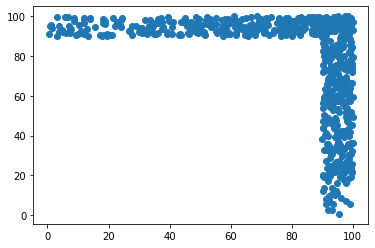

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

arr = np.array([spechum_for_coord],dtype="float",)
arr[arr < 0] = np.nan

cmap = ListedColormap(["green", "orangered"])
cmap.set_bad("silver")
plt.scatter(x=TW_percentile_toplot, y=precip_percentile_toplot, cmap=cmap)

In [25]:
#precip_90_pc
#stats.rankdata(precip_90_pc, "average")/len(precip_90_pc)
spechum_avg
import matplotlib as mpl
import matplotlib.cm as cm
   
norm = mpl.colors.Normalize(vmin=-20, vmax=10)
cmap = cm.hot
x = spechum_avg

m = cm.ScalarMappable(norm=norm, cmap=cmap)
print(m.to_rgba(x))

(1.0, 0.7916663385421999, 0.0, 1.0)


Text(0.5, 1.0, 'Extreme Precipitation and Wet Bulb Temperature (Northern Hemisphere, JJA)')

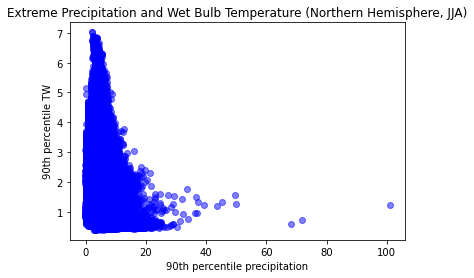

In [16]:
plt.scatter(raw_percentile_cutoff_JJA,raw_TW_percentile_cutoff_JJA,c="Blue", alpha=0.5)
plt.xlabel('90th percentile precipitation')
plt.ylabel('90th percentile TW')
plt.title('Extreme Precipitation and Wet Bulb Temperature (Northern Hemisphere, JJA)')

In [35]:
precip_raveled = precip_data_for_coordinate.values.ravel()
tw_raveled = TW_data_for_coordinate.values.ravel() 
extreme_precip_cutoff = np.nanpercentile(precip_raveled[precip_raveled > 0], q=90)
extreme_TW_cutoff = np.nanpercentile(tw_raveled[tw_raveled > 0], q=90)

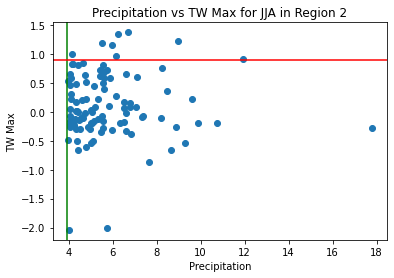

In [36]:
plt.scatter(precip_raveled[precip_raveled > extreme_precip_cutoff], tw_raveled[precip_raveled > extreme_precip_cutoff])

plt.axvline(x=extreme_precip_cutoff, color='g')
plt.axhline(y=extreme_TW_cutoff, color='r')
plt.xlabel('Precipitation')
plt.ylabel('TW Max')
plt.title('Precipitation vs TW Max for JJA in Region 2')
plt.show()